Compara modelos de clasificación por tecnica de remuestreo

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from itertools import cycle


%matplotlib inline
sns.set_style("whitegrid")

In [90]:
df =  pd.read_csv('D:/Alvaro/Posgrado/Tesis Transferencia/202304  - Analisis/Dataset/dataset_completo.csv', sep=';')
print("Full dataset has",df.shape[0], "rows and", df.shape[1], "columns")


Full dataset has 567248 rows and 15 columns


In [91]:
df['Class'] = df['V01'] 

df = df.drop('V01', axis=1)
df = df.drop('V02', axis=1)
df = df.drop('id', axis=1)


scores_df = pd.DataFrame(columns=['tipo_muestreo', 'clasificador', 'recall_tipo_1'])
scores_rroc_df = pd.DataFrame(columns=['clasificador','tipo_muestreo', 'resu_rroc'])

LABELS = ['Normal','Fraudulent']


Pre procesamiento

In [92]:

X = df.drop('Class', axis=1)
y = df.Class

X_train_o, X_test, y_train_o, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42)


In [93]:
print(f"Entrenamiento: X_train: {X_train_o.shape}, y_train: {y_train_o.shape}\n{'_'*55}")
print(f"Testing: X_test: {X_test.shape}, y_test: {y_test.shape}")

Entrenamiento: X_train: (397073, 12), y_train: (397073,)
_______________________________________________________
Testing: X_test: (170175, 12), y_test: (170175,)


Funciones de modelado

In [94]:
#Funciona para mostrar y acumular los resultados
def mostrar_resultados(y_test, pred_y, tipo_modelo, tipo_nuestreo):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

    Clasif_report = classification_report(y_test, pred_y, output_dict=True)

    rroc = precision_recall_curve(y_test, pred_y)   

    resultado = pd.DataFrame({'tipo_muestreo': [tipo_nuestreo], 'clasificador': [tipo_modelo], 'recall_tipo_1':[Clasif_report['1']['recall']]})
    resu_rroc = pd.DataFrame({'clasificador': [tipo_modelo], 'tipo_muestreo': [tipo_nuestreo], 'resu_rroc': [rroc]})

    return resultado, resu_rroc



#Función para modelar con cada algoritmo
def ejecuta_modelo(X_train, X_test, y_train, y_test, tipo_modelo, tipo_nuestreo):

    print(tipo_modelo)

    if (tipo_modelo == 'XGBoost'):
        modelo = XGBClassifier()
        modelo.fit(X_train, y_train)


    if (tipo_modelo == 'Random Forest'):  
        modelo = RandomForestClassifier(n_estimators=100, oob_score=False,random_state=42)
        modelo.fit(X_train, y_train)


    if (tipo_modelo == 'LGBM'):  
        modelo = LGBMClassifier()
        modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)
    resultado, rroc = mostrar_resultados(y_test, y_pred, tipo_modelo, tipo_nuestreo)
    
    

    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(X.columns[np.argsort(modelo.feature_importances_)][::-1], 
        sorted(modelo.feature_importances_, reverse=True),
        align='center')
    ax.set_yticks(X.columns)
    ax.invert_yaxis() 
    ax.set_xlabel('Importance')

    return resultado, rroc

    


Dataset Normal

Txs Fraudulentas: 458
Txs genuinas: 396615
XGBoost
XGBoost


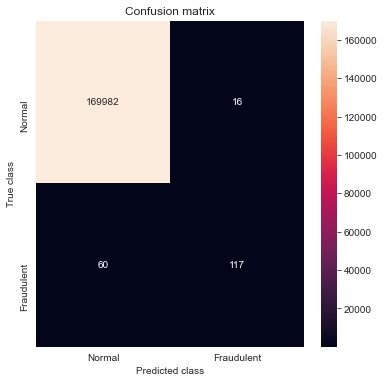

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.88      0.66      0.75       177

    accuracy                           1.00    170175
   macro avg       0.94      0.83      0.88    170175
weighted avg       1.00      1.00      1.00    170175

Random Forest
Random Forest


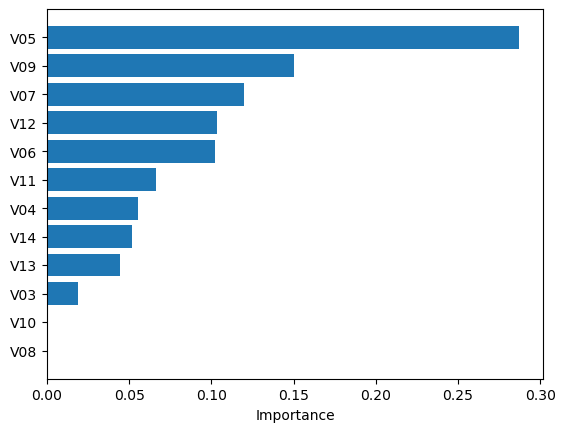

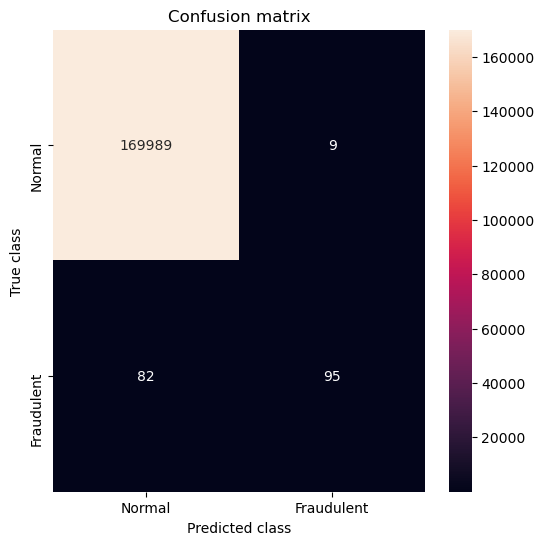

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.91      0.54      0.68       177

    accuracy                           1.00    170175
   macro avg       0.96      0.77      0.84    170175
weighted avg       1.00      1.00      1.00    170175

LGBM
LGBM


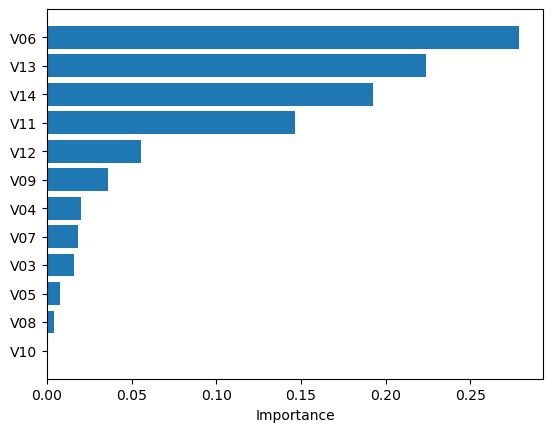

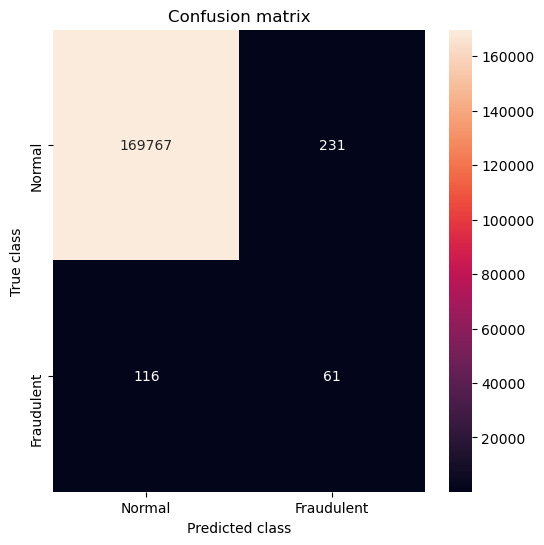

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.21      0.34      0.26       177

    accuracy                           1.00    170175
   macro avg       0.60      0.67      0.63    170175
weighted avg       1.00      1.00      1.00    170175



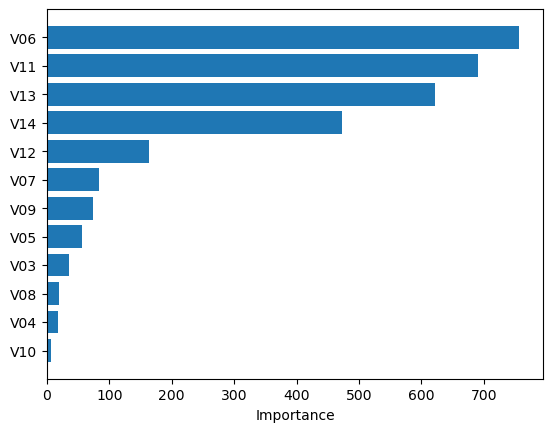

In [95]:

Normal_tx = y_train_o.value_counts()[0]
fraud_tx = y_train_o.value_counts()[1]

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")


tipo_nuestreo = '1 - Original'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train_o, X_test, y_train_o, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train_o, X_test, y_train_o, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train_o, X_test, y_train_o, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

UNDER SAMPLING

Random under-sampling(RUS)

Txs Fraudulentas: 458
Txs genuinas: 458
XGBoost
XGBoost


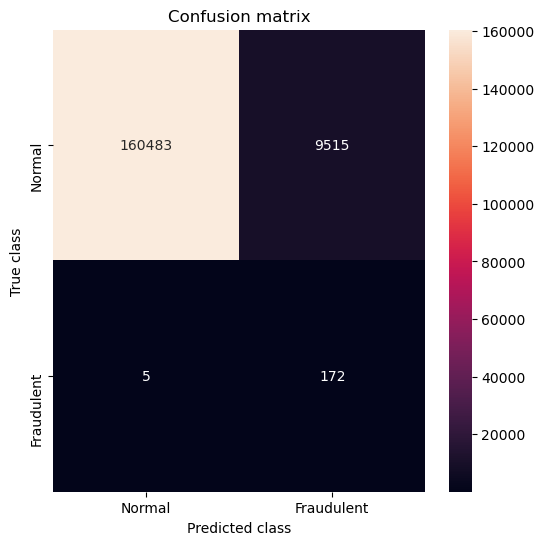

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    169998
           1       0.02      0.97      0.03       177

    accuracy                           0.94    170175
   macro avg       0.51      0.96      0.50    170175
weighted avg       1.00      0.94      0.97    170175

Random Forest
Random Forest


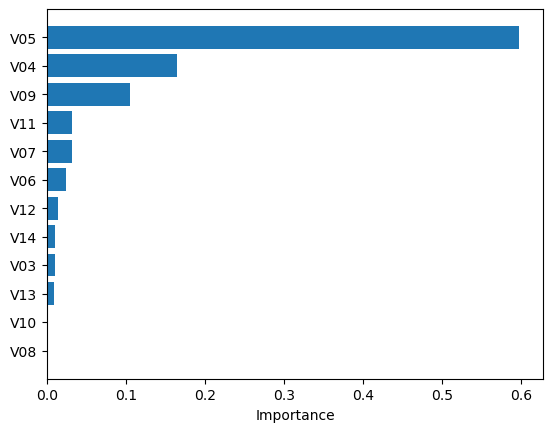

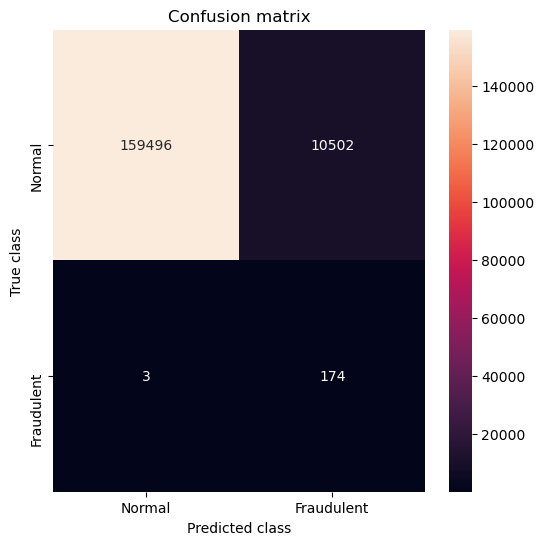

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    169998
           1       0.02      0.98      0.03       177

    accuracy                           0.94    170175
   macro avg       0.51      0.96      0.50    170175
weighted avg       1.00      0.94      0.97    170175

LGBM
LGBM


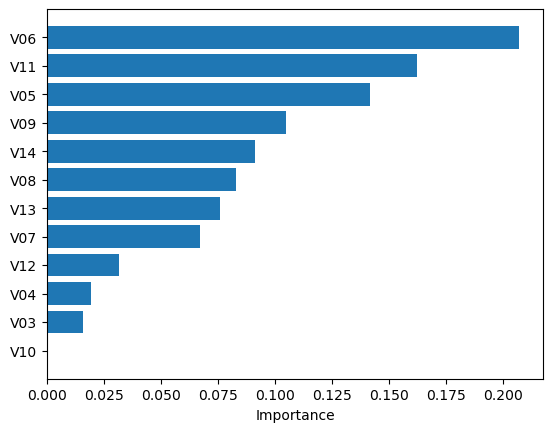

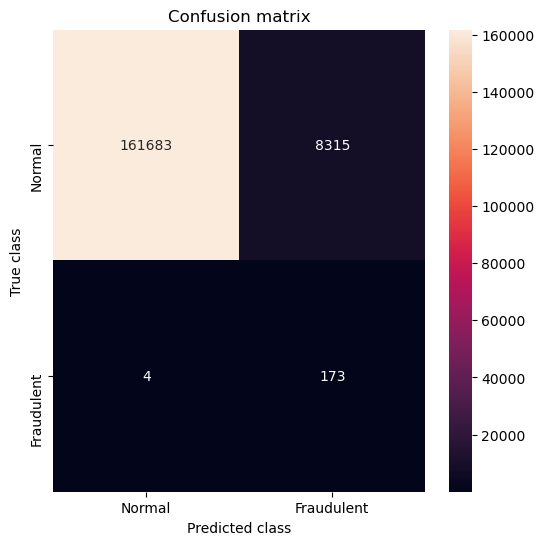

              precision    recall  f1-score   support

           0       1.00      0.95      0.97    169998
           1       0.02      0.98      0.04       177

    accuracy                           0.95    170175
   macro avg       0.51      0.96      0.51    170175
weighted avg       1.00      0.95      0.97    170175



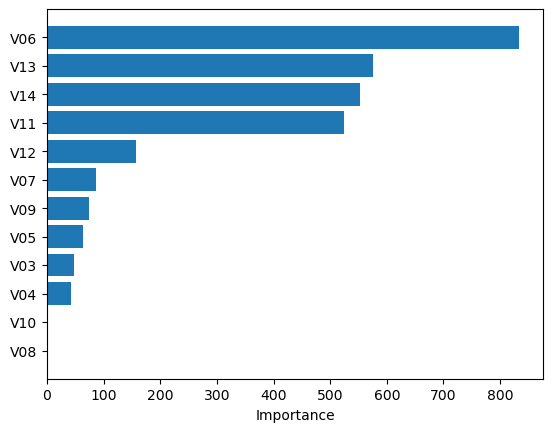

In [96]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_train, y_train = rus.fit_resample(X_train_o, y_train_o)

Normal_tx = y_train.value_counts()[0]
fraud_tx = y_train.value_counts()[1]

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '2 - Random under-sampling'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


CLUSTERING

Txs Fraudulentas: 458
Txs genuinas: 388780
XGBoost
XGBoost


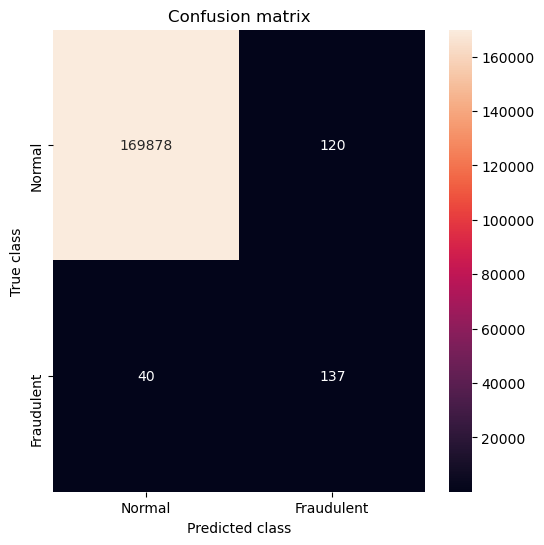

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.53      0.77      0.63       177

    accuracy                           1.00    170175
   macro avg       0.77      0.89      0.82    170175
weighted avg       1.00      1.00      1.00    170175

Random Forest
Random Forest


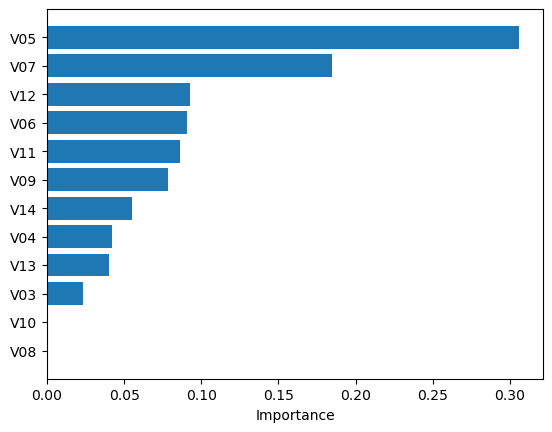

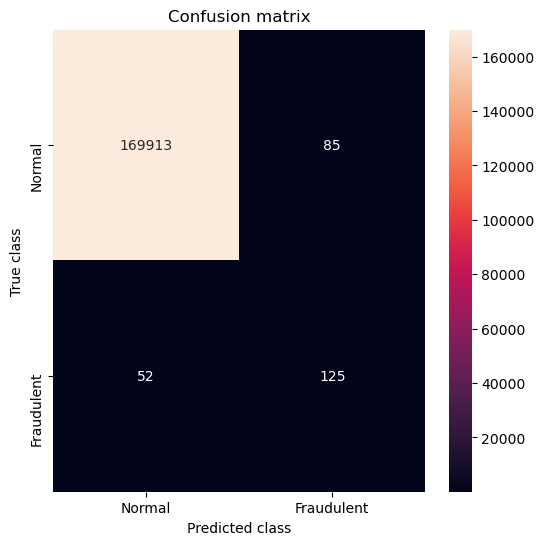

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.60      0.71      0.65       177

    accuracy                           1.00    170175
   macro avg       0.80      0.85      0.82    170175
weighted avg       1.00      1.00      1.00    170175

LGBM
LGBM


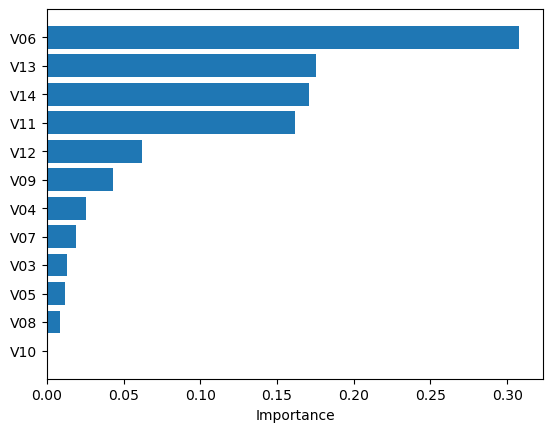

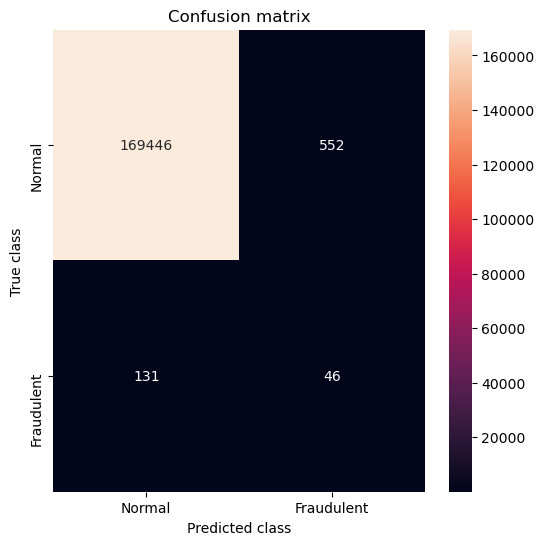

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.08      0.26      0.12       177

    accuracy                           1.00    170175
   macro avg       0.54      0.63      0.56    170175
weighted avg       1.00      1.00      1.00    170175



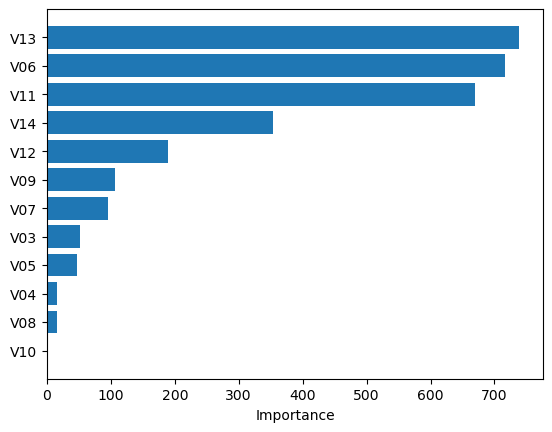

In [97]:

from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids()

from imblearn.under_sampling import InstanceHardnessThreshold
iht = InstanceHardnessThreshold(random_state=42)

X_train, y_train = iht.fit_resample(X_train_o, y_train_o)

Normal_tx = y_train.value_counts()[0]
fraud_tx = y_train.value_counts()[1]

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '3 - Cluster Centroids'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

OVER SAMPLING

Random over-sampling (ROS)

Txs Fraudulentas: 396615
Txs genuinas: 396615
XGBoost
XGBoost


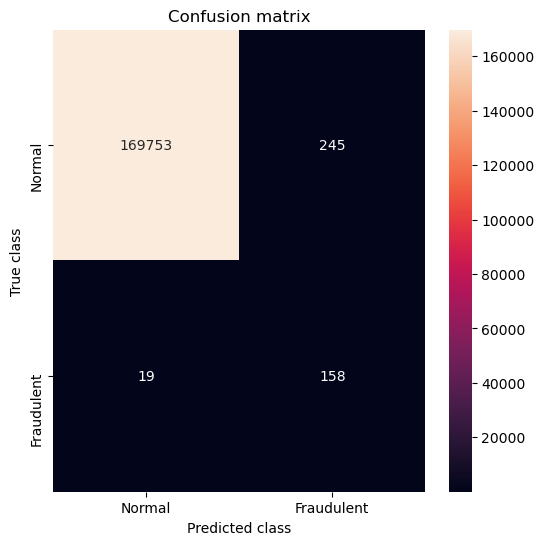

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.39      0.89      0.54       177

    accuracy                           1.00    170175
   macro avg       0.70      0.95      0.77    170175
weighted avg       1.00      1.00      1.00    170175

Random Forest
Random Forest


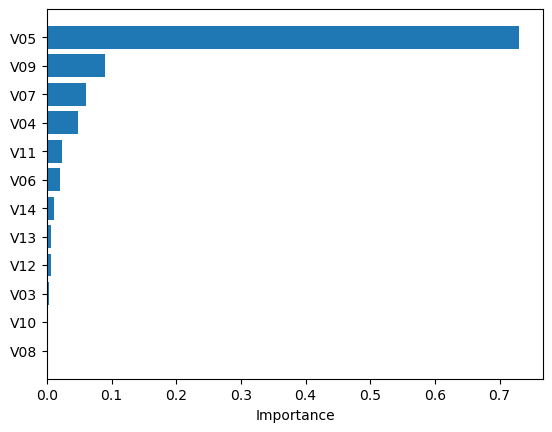

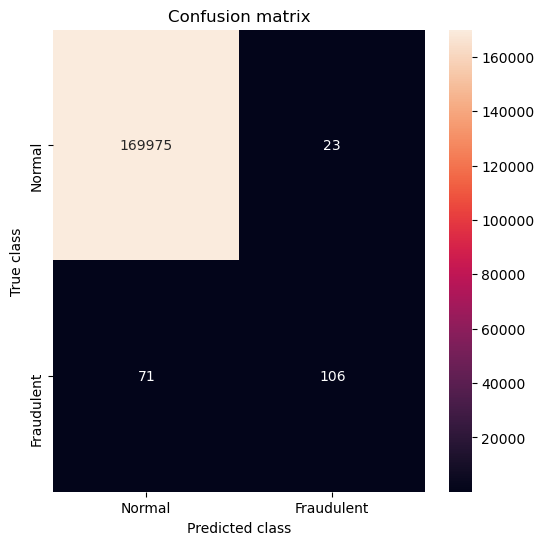

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.82      0.60      0.69       177

    accuracy                           1.00    170175
   macro avg       0.91      0.80      0.85    170175
weighted avg       1.00      1.00      1.00    170175

LGBM
LGBM


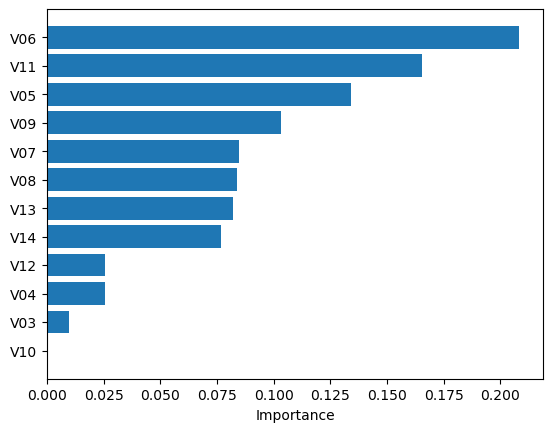

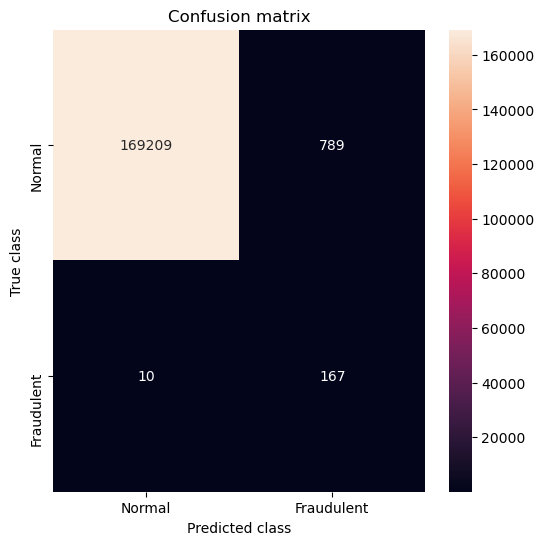

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.17      0.94      0.29       177

    accuracy                           1.00    170175
   macro avg       0.59      0.97      0.65    170175
weighted avg       1.00      1.00      1.00    170175



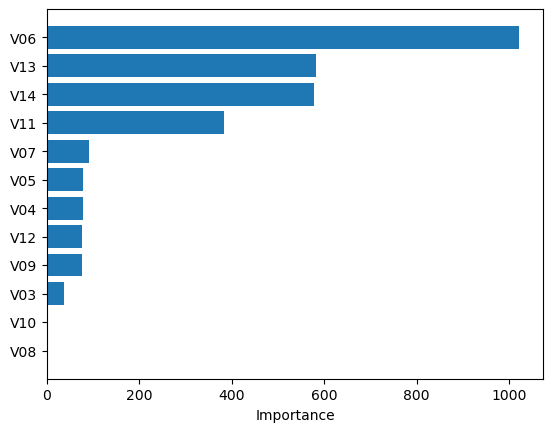

In [98]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train_o, y_train_o)

Normal_tx = y_train.value_counts()[0]
fraud_tx = y_train.value_counts()[1]

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '4 - Random over-sampling'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

SMOTE

Txs Fraudulentas: 396615
Txs genuinas: 396615
XGBoost
XGBoost


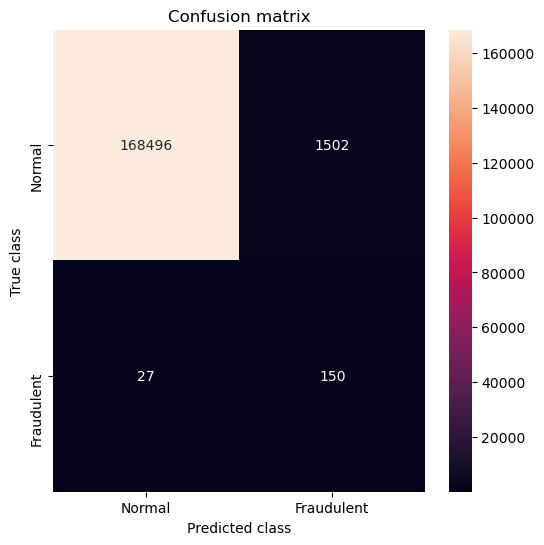

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    169998
           1       0.09      0.85      0.16       177

    accuracy                           0.99    170175
   macro avg       0.55      0.92      0.58    170175
weighted avg       1.00      0.99      0.99    170175

Random Forest
Random Forest


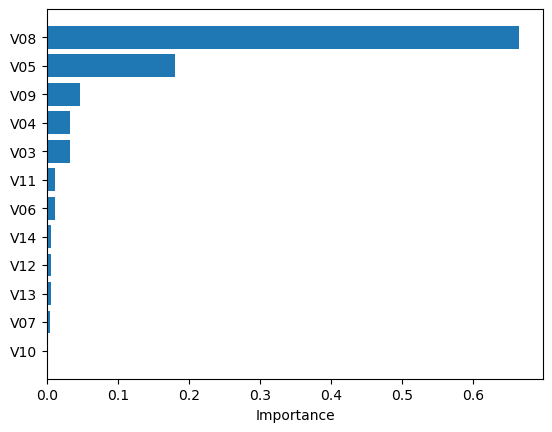

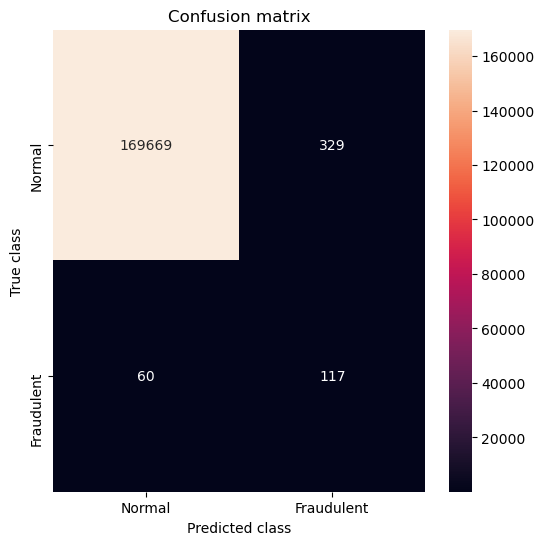

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.26      0.66      0.38       177

    accuracy                           1.00    170175
   macro avg       0.63      0.83      0.69    170175
weighted avg       1.00      1.00      1.00    170175

LGBM
LGBM


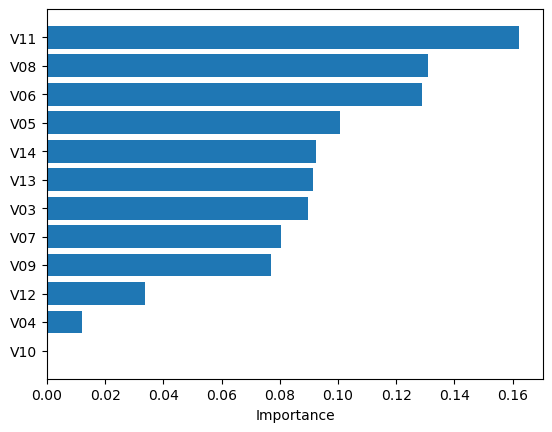

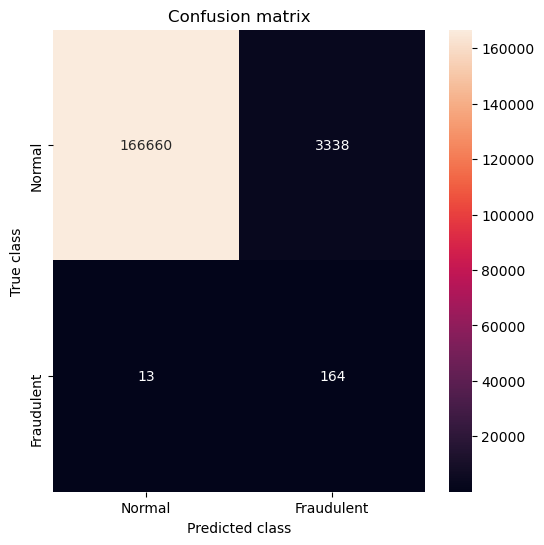

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    169998
           1       0.05      0.93      0.09       177

    accuracy                           0.98    170175
   macro avg       0.52      0.95      0.54    170175
weighted avg       1.00      0.98      0.99    170175



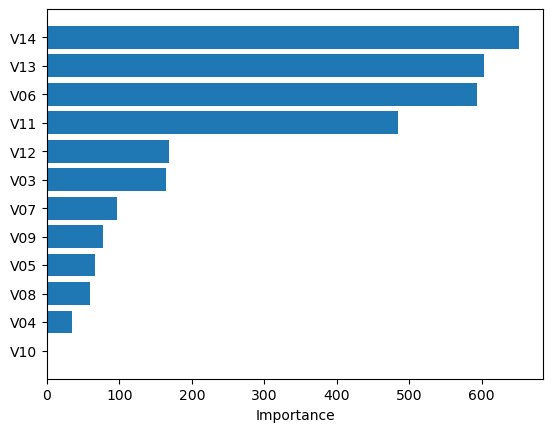

In [99]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
#smote = SMOTE(ratio='minority')
X_train, y_train = smote.fit_resample(X_train_o, y_train_o)

Normal_tx = y_train.value_counts()[0]
fraud_tx = y_train.value_counts()[1]

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '5 - SMOTE'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

ADASYN

Txs Fraudulentas: 396491
Txs genuinas: 396615
XGBoost
XGBoost


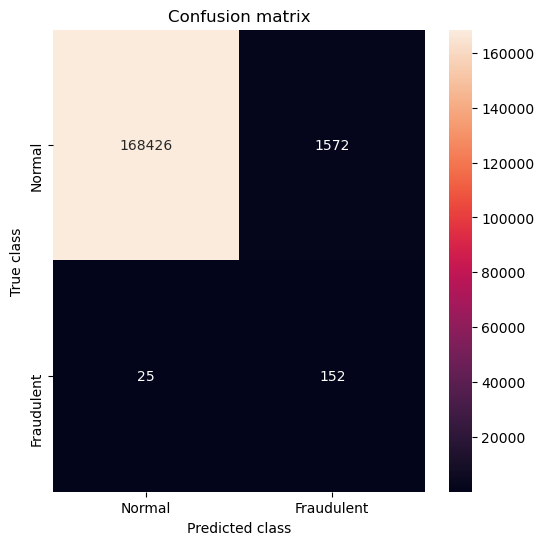

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    169998
           1       0.09      0.86      0.16       177

    accuracy                           0.99    170175
   macro avg       0.54      0.92      0.58    170175
weighted avg       1.00      0.99      0.99    170175

Random Forest
Random Forest


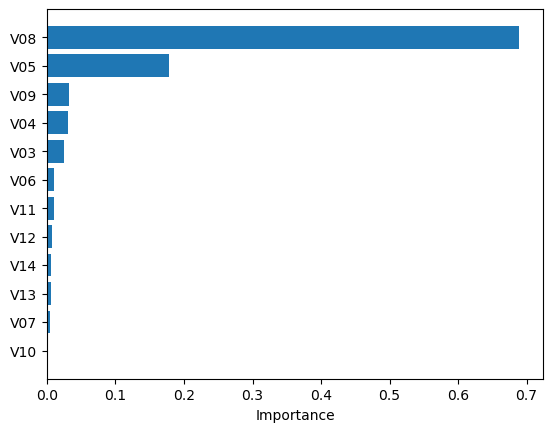

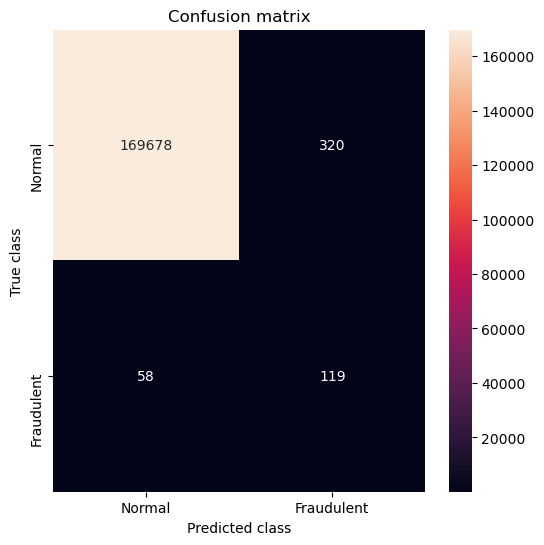

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.27      0.67      0.39       177

    accuracy                           1.00    170175
   macro avg       0.64      0.84      0.69    170175
weighted avg       1.00      1.00      1.00    170175

LGBM
LGBM


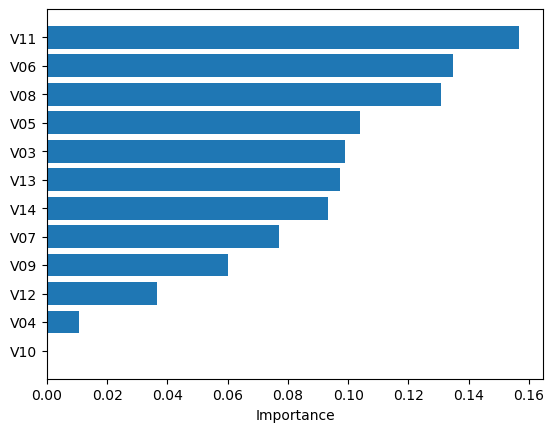

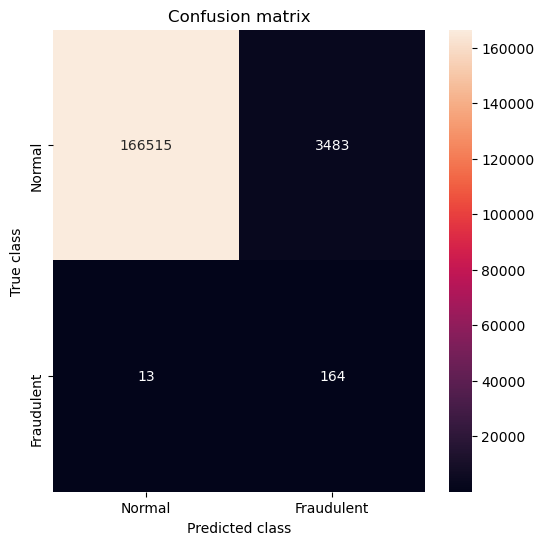

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    169998
           1       0.04      0.93      0.09       177

    accuracy                           0.98    170175
   macro avg       0.52      0.95      0.54    170175
weighted avg       1.00      0.98      0.99    170175



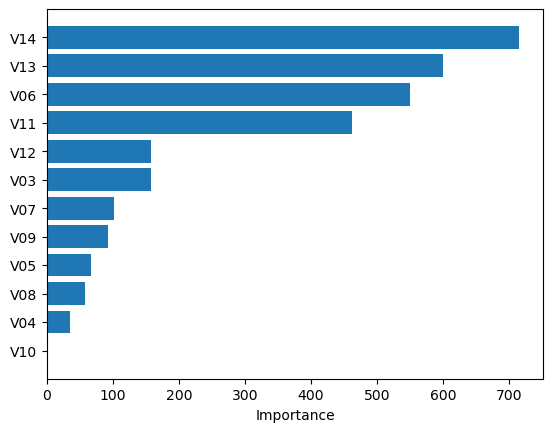

In [100]:
from imblearn.over_sampling import ADASYN

X_train, y_train = ADASYN().fit_resample(X_train_o, y_train_o)

Normal_tx = y_train.value_counts()[0]
fraud_tx = y_train.value_counts()[1]

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '6 - ADASYN'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

Convinación OVER AND UNDER SAMPLING

SMOTE TOMEK

Txs Fraudulentas: 396273
Txs genuinas: 396273
XGBoost
XGBoost


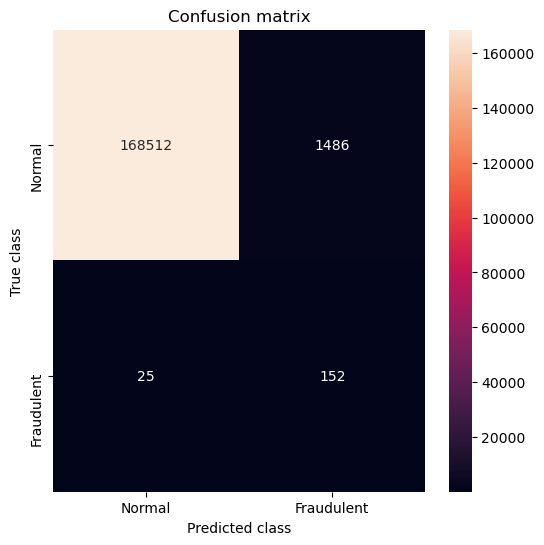

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    169998
           1       0.09      0.86      0.17       177

    accuracy                           0.99    170175
   macro avg       0.55      0.93      0.58    170175
weighted avg       1.00      0.99      0.99    170175

Random Forest
Random Forest


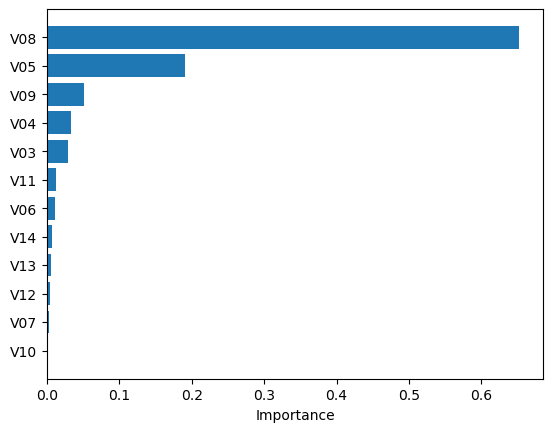

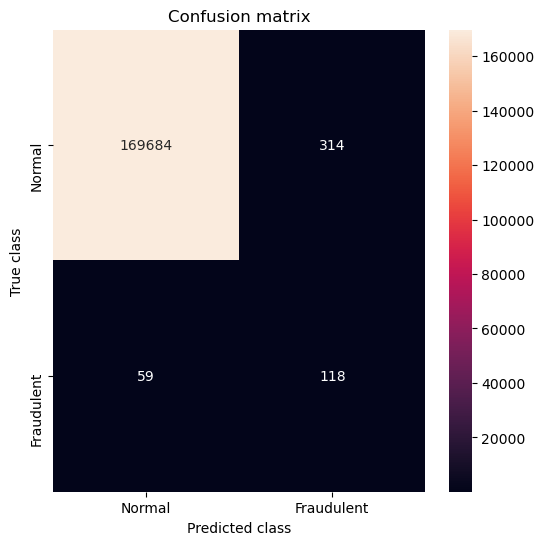

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.27      0.67      0.39       177

    accuracy                           1.00    170175
   macro avg       0.64      0.83      0.69    170175
weighted avg       1.00      1.00      1.00    170175

LGBM
LGBM


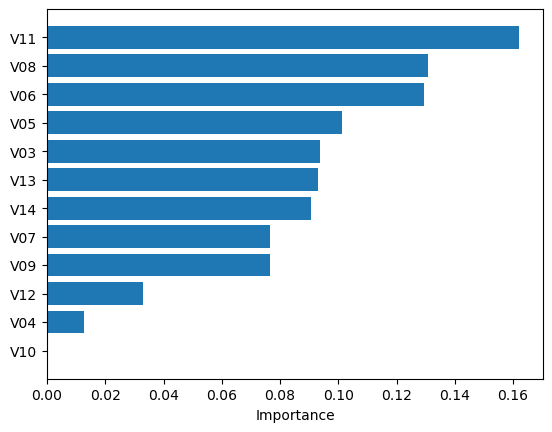

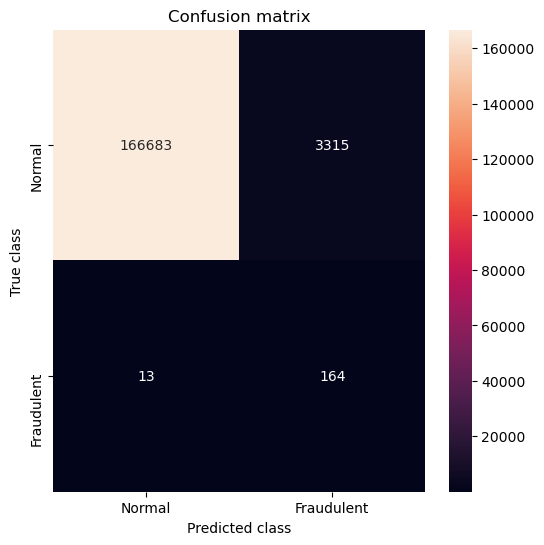

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    169998
           1       0.05      0.93      0.09       177

    accuracy                           0.98    170175
   macro avg       0.52      0.95      0.54    170175
weighted avg       1.00      0.98      0.99    170175



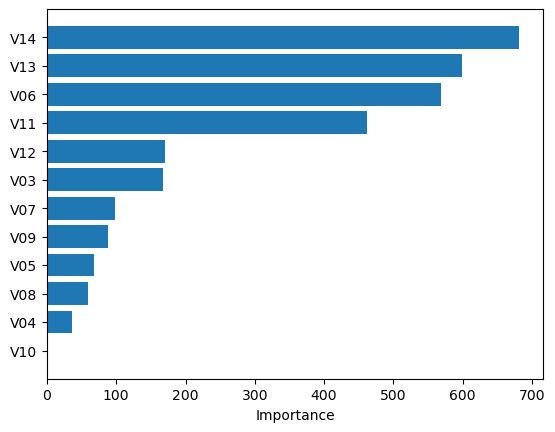

In [101]:
from imblearn.combine import SMOTETomek

tomek = SMOTETomek()
X_train, y_train = tomek.fit_resample(X_train_o, y_train_o)

Normal_tx = y_train.value_counts()[0]
fraud_tx = y_train.value_counts()[1]

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '7 - SMOTE TOMEK'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

SMOTE ENN

Txs Fraudulentas: 0.5073757693846214
Txs genuinas: 0.49262423061537863
XGBoost
XGBoost


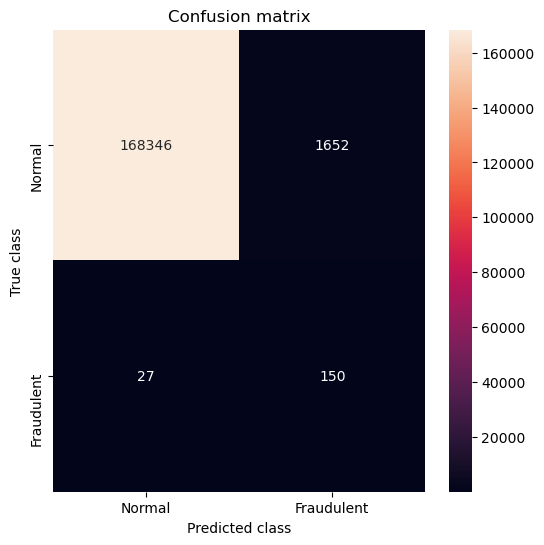

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    169998
           1       0.08      0.85      0.15       177

    accuracy                           0.99    170175
   macro avg       0.54      0.92      0.57    170175
weighted avg       1.00      0.99      0.99    170175

Random Forest
Random Forest


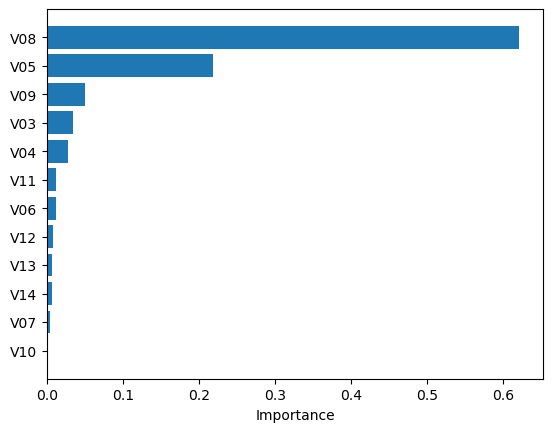

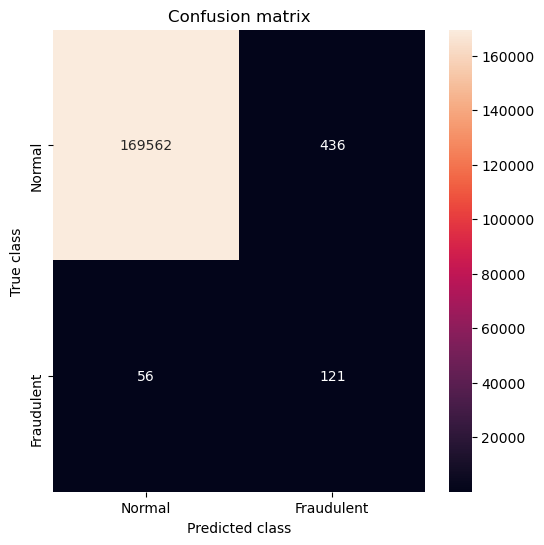

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    169998
           1       0.22      0.68      0.33       177

    accuracy                           1.00    170175
   macro avg       0.61      0.84      0.66    170175
weighted avg       1.00      1.00      1.00    170175

LGBM
LGBM


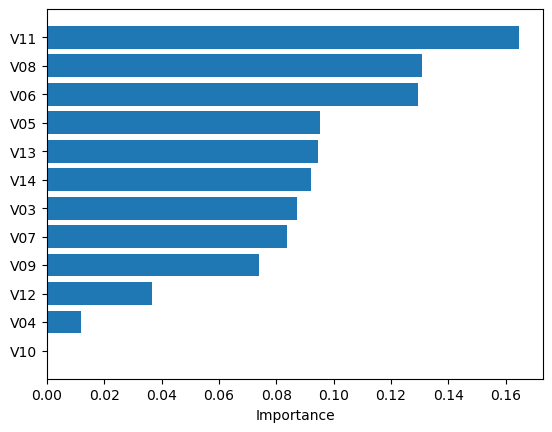

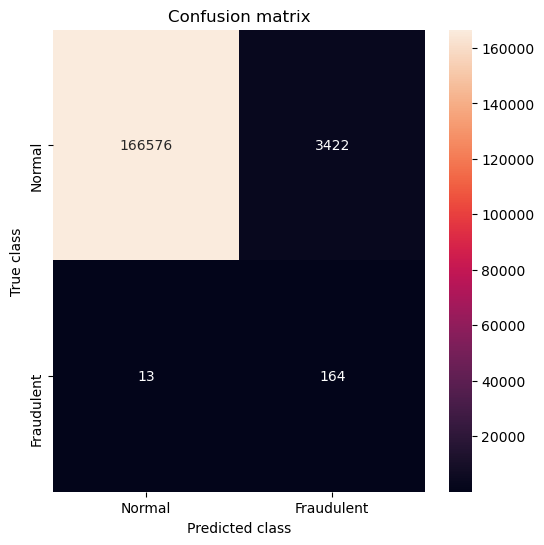

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    169998
           1       0.05      0.93      0.09       177

    accuracy                           0.98    170175
   macro avg       0.52      0.95      0.54    170175
weighted avg       1.00      0.98      0.99    170175



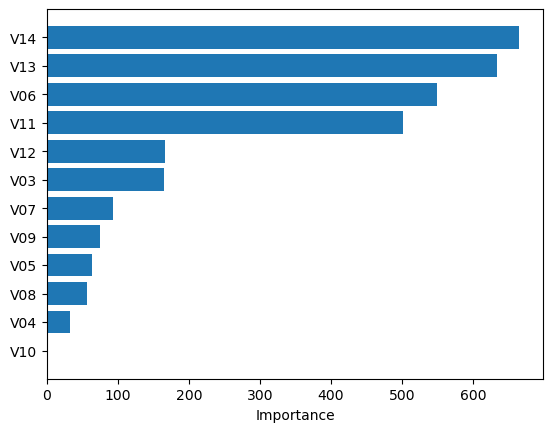

In [102]:
from imblearn.combine import SMOTEENN

sme = SMOTEENN(random_state=42)

X_train, y_train = sme.fit_resample(X_train_o, y_train_o)

Normal_tx = y_train.value_counts()[0] / len(y_train)
fraud_tx = y_train.value_counts()[1] / len(y_train)

print(f"Txs Fraudulentas: {fraud_tx}")
print(f"Txs genuinas: {Normal_tx}")

tipo_nuestreo = '8 - SMOTEENN'

# xgboost
print(f'XGBoost')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'XGBoost', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)


# Random Forest
print(f'Random Forest')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'Random Forest', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

# LigthGBM
print(f'LGBM')
resultado, rroc = ejecuta_modelo(X_train, X_test, y_train, y_test,'LGBM', tipo_nuestreo)
scores_df = scores_df.append(resultado, ignore_index=True)
scores_rroc_df = scores_rroc_df.append(rroc, ignore_index=True)

Comparacion de Modelos

[]

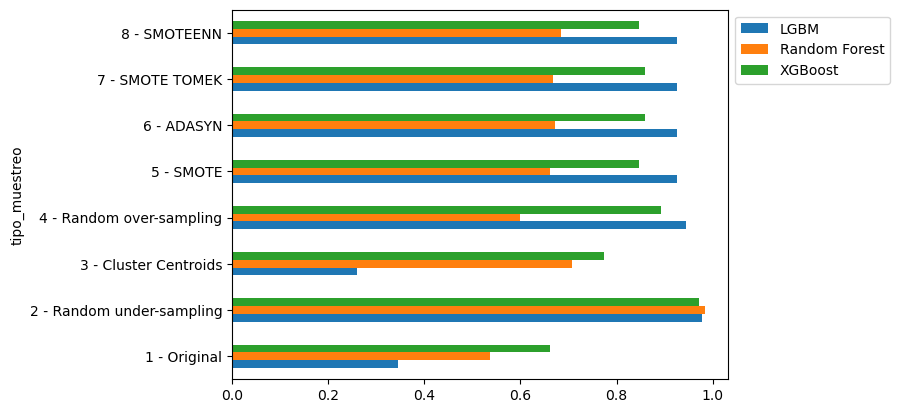

In [103]:
df_pivot = pd.pivot_table(
	scores_df,
	values="recall_tipo_1",
	index="tipo_muestreo",
	columns="clasificador",
	aggfunc=np.mean
)


# Plot a bar chart using the DF

ax = df_pivot.plot(kind="barh")
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

Curvas RROC por Clasificador y tecnica de remuestreo

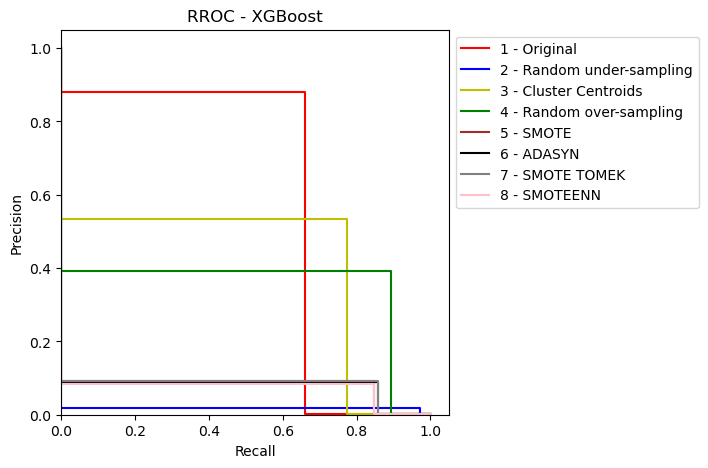

In [118]:
colors = cycle(["r","b", "y", "g", "brown", "k", "grey","pink"])

_, ax = plt.subplots(figsize=(5, 5))

df_grafico = scores_rroc_df[scores_rroc_df['clasificador']== 'XGBoost']
df_grafico = df_grafico.reset_index()

for i, color in zip(range(len(df_grafico)), colors):
       
    precision, recall, _ = df_grafico.loc[i,"resu_rroc"]
    display = PrecisionRecallDisplay(recall=recall, precision=precision)
    display.plot(ax=ax, name=f"{df_grafico.loc[i,'tipo_muestreo']}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()

# set the legend and the axes


ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.0, 1.0))
ax.set_title("RROC - XGBoost")

plt.show()

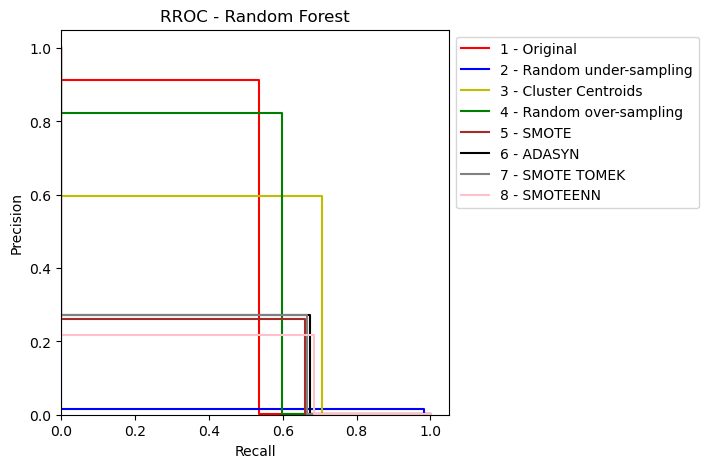

In [119]:
colors = cycle(["r","b", "y", "g", "brown", "k", "grey","pink"])

_, ax = plt.subplots(figsize=(5, 5))

df_grafico = scores_rroc_df[scores_rroc_df['clasificador']== 'Random Forest']
df_grafico = df_grafico.reset_index()

for i, color in zip(range(len(df_grafico)), colors):
       
    precision, recall, _ = df_grafico.loc[i,"resu_rroc"]
    display = PrecisionRecallDisplay(recall=recall, precision=precision)
    display.plot(ax=ax, name=f"{df_grafico.loc[i,'tipo_muestreo']}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()

# set the legend and the axes
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.0, 1.0))
ax.set_title("RROC - Random Forest")

plt.show()

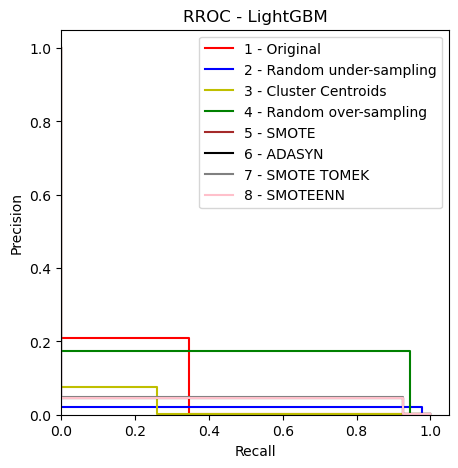

In [120]:
colors = cycle(["r","b", "y", "g", "brown", "k", "grey","pink"])

_, ax = plt.subplots(figsize=(5, 5))

df_grafico = scores_rroc_df[scores_rroc_df['clasificador']== 'LGBM']
df_grafico = df_grafico.reset_index()

for i, color in zip(range(len(df_grafico)), colors):
       
    precision, recall, _ = df_grafico.loc[i,"resu_rroc"]
    display = PrecisionRecallDisplay(recall=recall, precision=precision)
    display.plot(ax=ax, name=f"{df_grafico.loc[i,'tipo_muestreo']}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()


# set the legend and the axes
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.0, 1.0))
ax.set_title("RROC - LightGBM")

plt.show()